In [3]:
# geocapnet.py — Multimodal Image Captioning for Geometric Shapes (Image → Text)
# Author: You :)
# Task: Generate synthetic RGB images with 1–2 colored shapes; caption them in natural language.
#
# Example captions:
#   "a red circle"
#   "a blue square and a green triangle"
#
# Architecture:
#   - Vision encoder: lightweight CNN → feature vector
#   - Text decoder: Embedding + GRU → token sequence
#
# Training:
#   - Supervised teacher forcing with CrossEntropyLoss (PAD ignored)
#
# Outputs:
#   - Training loss curve
#   - A 4x3 grid of test images with True vs. Predicted captions


In [2]:
import os, math, random, numpy as np
from typing import List, Tuple
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [4]:
# --------------------
# Config
# --------------------
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [5]:
IMG_SIZE = 96                 # RGB image size
BATCH_SIZE = 48
EPOCHS = 12
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
COLORS = {
    "red":    (220, 50, 47),
    "green":  (38, 139, 210-210+142),  # ~slate-ish green to avoid neon; still distinct
    "blue":   (38, 139, 210),
    "yellow": (253, 231, 76),
}
COLOR_NAMES = list(COLORS.keys())
SHAPES = ["circle", "square", "triangle"]

In [7]:
# Caption grammar: (a) <color> <shape> [and a <color> <shape>]
# Vocabulary kept tight for quick convergence
VOCAB = ["<PAD>", "<SOS>", "<EOS>", "a", "and"] + COLOR_NAMES + SHAPES
WORD2IDX = {w:i for i,w in enumerate(VOCAB)}
IDX2WORD = {i:w for w,i in WORD2IDX.items()}
PAD, SOS, EOS = WORD2IDX["<PAD>"], WORD2IDX["<SOS>"], WORD2IDX["<EOS>"]
VOCAB_SIZE = len(VOCAB)

In [8]:
EMB_DIM = 64
HIDDEN_DIM = 128
MAX_TOKENS_SINGLE = 1 + 1 + 1 + 1 + 1    # <SOS> a color shape <EOS>  → 5 tokens
MAX_TOKENS_DOUBLE = 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1  # <SOS> a c s and a c s <EOS> → 8
MAX_LEN = MAX_TOKENS_DOUBLE  # Pad to the longest form

In [9]:
# --------------------
# Drawing helpers
# --------------------
def _rand_bbox(sz: int, min_size: int = 18, max_size: int = 36) -> Tuple[int,int,int,int]:
    s = np.random.randint(min_size, max_size)
    x1 = np.random.randint(4, sz - s - 4)
    y1 = np.random.randint(4, sz - s - 4)
    return x1, y1, x1 + s, y1 + s


In [10]:
def _draw_circle(draw: ImageDraw.Draw, bbox, color):
    draw.ellipse(bbox, fill=color, outline=None, width=0)

In [11]:
def _draw_square(draw: ImageDraw.Draw, bbox, color):
    draw.rectangle(bbox, fill=color, outline=None, width=0)

In [12]:
def _draw_triangle(draw: ImageDraw.Draw, bbox, color):
    x1, y1, x2, y2 = bbox
    w, h = x2 - x1, y2 - y1
    # point up
    p1 = (x1 + w//2, y1)
    p2 = (x1, y2)
    p3 = (x2, y2)
    draw.polygon([p1, p2, p3], fill=color, outline=None)


In [13]:
DRAW_FN = {
    "circle": _draw_circle,
    "square": _draw_square,
    "triangle": _draw_triangle,
}

In [14]:
def draw_shape(img: Image.Image, shape: str, color_name: str):
    draw = ImageDraw.Draw(img)
    bbox = _rand_bbox(IMG_SIZE)
    DRAW_FN[shape](draw, bbox, COLORS[color_name])

In [15]:
# --------------------
# Caption templating
# --------------------
def make_caption_tokens(one_or_two, c1, s1, c2=None, s2=None) -> List[str]:
    if one_or_two == 1:
        return ["<SOS>", "a", c1, s1, "<EOS>"]
    else:
        # "a c1 s1 and a c2 s2"
        return ["<SOS>", "a", c1, s1, "and", "a", c2, s2, "<EOS>"]

In [16]:
def tokens_to_ids(tokens: List[str], max_len=MAX_LEN) -> List[int]:
    ids = [WORD2IDX[t] for t in tokens]
    if len(ids) < max_len:
        ids += [PAD] * (max_len - len(ids))
    return ids[:max_len]

In [17]:
def ids_to_sentence(ids: List[int]) -> str:
    words = [IDX2WORD[i] for i in ids if i not in (PAD, SOS, EOS)]
    return " ".join(words)


In [18]:
# --------------------
# Synthetic dataset
# --------------------
class GeoShapesDataset(Dataset):
    """
    Generates images with 1–2 colored shapes and corresponding caption tokens.
    """
    def __init__(self, n_samples=2000):
        self.n = n_samples
        self.images = []
        self.targets = []
        for _ in range(n_samples):
            img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (255, 255, 255))
            k = np.random.choice([1, 2], p=[0.6, 0.4])  # slightly more singles than doubles
            c1, s1 = random.choice(COLOR_NAMES), random.choice(SHAPES)
            draw_shape(img, s1, c1)
            if k == 2:
                c2, s2 = random.choice(COLOR_NAMES), random.choice(SHAPES)
                draw_shape(img, s2, c2)
                toks = make_caption_tokens(2, c1, s1, c2, s2)
            else:
                toks = make_caption_tokens(1, c1, s1)

            arr = np.asarray(img).astype(np.float32) / 255.0
            self.images.append(arr.transpose(2,0,1))  # HWC→CHW
            self.targets.append(tokens_to_ids(toks, MAX_LEN))

        self.images = torch.tensor(np.stack(self.images), dtype=torch.float32)
        self.targets = torch.tensor(np.stack(self.targets), dtype=torch.long)

    def __len__(self): return self.n
    def __getitem__(self, idx):
        return self.images[idx], self.targets[idx]


In [28]:
# --------------------
# Model: CNN encoder + GRU decoder
# --------------------
class GeoCapNet(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, emb_dim=EMB_DIM, hidden_dim=HIDDEN_DIM):
        super().__init__()
        # Vision encoder — lightweight CNN
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),     # 48x48
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),    # 24x24
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # 12x12
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
        )
        self.enc2hid = nn.Linear(128, hidden_dim)

        # Text decoder
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.gru = nn.GRU(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, images, captions):
        # Encode image → initial hidden state h0
        feat = self.encoder(images)                 # [B, 128]
        h0 = self.enc2hid(feat).unsqueeze(0)        # [1, B, H]
        # Teacher forcing: input is captions[:, :-1], target is captions[:, 1:]
        emb = self.embed(captions[:, :-1])          # [B, T-1, E]
        out, _ = self.gru(emb, h0)                  # [B, T-1, H]
        logits = self.fc(out)                       # [B, T-1, V]
        return logits

    @torch.no_grad()
    def generate(self, image, max_len=MAX_LEN):
        self.eval()
        feat = self.encoder(image.unsqueeze(0))   # [1, 128]
        h = self.enc2hid(feat).unsqueeze(0)       # [1, 1, H]
        w = torch.tensor([[SOS]], device=image.device)  # [1,1]
        caption_ids = []
        for _ in range(max_len):
            emb = self.embed(w)                   # [1,1,E]
            out, h = self.gru(emb, h)            # [1,1,H]
            logits = self.fc(out[:, -1, :])      # [1,V]
            w = torch.argmax(logits, dim=1).view(1,1)
            token_id = w.item()
            if token_id == EOS or token_id == PAD: break
            caption_ids.append(token_id)
            # next input is the predicted token
        return ids_to_sentence(caption_ids)

In [29]:
# --------------------
# Training loop
# --------------------
def train():
    # Datasets
    train_ds = GeoShapesDataset(2200)
    val_ds   = GeoShapesDataset(400)
    test_ds  = GeoShapesDataset(300)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

    model = GeoCapNet().to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)

    history = []
    for epoch in range(1, EPOCHS+1):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)       # yb: [B,T]
            logits = model(xb, yb)                       # [B,T-1,V]
            loss = loss_fn(
                logits.reshape(-1, VOCAB_SIZE),          # [(B*(T-1)), V]
                yb[:, 1:].reshape(-1)                    # next-token targets
            )
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        train_loss = total / len(train_loader)

        # Val loss
        model.eval(); vtotal = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb, yb)
                vloss = loss_fn(logits.reshape(-1, VOCAB_SIZE), yb[:,1:].reshape(-1))
                vtotal += vloss.item()
        val_loss = vtotal / len(val_loader)
        history.append((train_loss, val_loss))
        print(f"Epoch {epoch:02d}/{EPOCHS} | Train {train_loss:.3f} | Val {val_loss:.3f}")

    # Plot loss
    tr = [t for t, _ in history]; va = [v for _, v in history]
    plt.figure()
    plt.plot(tr, label="train"); plt.plot(va, label="val")
    plt.title("Cross-Entropy Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.show()

    # Evaluate qualitatively on test samples
    show_predictions_grid(model, test_ds)


In [30]:
def show_predictions_grid(model: GeoCapNet, dataset: GeoShapesDataset, n_show: int = 12):
    idxs = np.random.choice(len(dataset), size=n_show, replace=False)
    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=(12, 9))
    for i, idx in enumerate(idxs):
        img, tgt = dataset[idx]
        img_t = img.to(DEVICE)
        pred_caption = model.generate(img_t)
        true_caption = ids_to_sentence(tgt.tolist())
        ax = axes[i // cols, i % cols]
        ax.imshow(img.permute(1,2,0).numpy())
        ax.set_title(f"Pred: {pred_caption}", fontsize=9)
        ax.set_xlabel(f"True: {true_caption}", fontsize=8)
        ax.set_xticks([]); ax.set_yticks([])
    plt.suptitle("GeoCapNet — Image→Text Captioning for Colored Shapes", fontsize=14)
    plt.tight_layout()
    plt.show()


Epoch 01/12 | Train 1.319 | Val 0.845
Epoch 02/12 | Train 0.827 | Val 0.819
Epoch 03/12 | Train 0.809 | Val 0.806
Epoch 04/12 | Train 0.775 | Val 0.716
Epoch 05/12 | Train 0.700 | Val 0.710
Epoch 06/12 | Train 0.631 | Val 0.572
Epoch 07/12 | Train 0.551 | Val 0.526
Epoch 08/12 | Train 0.518 | Val 0.498
Epoch 09/12 | Train 0.473 | Val 0.473
Epoch 10/12 | Train 0.444 | Val 0.467
Epoch 11/12 | Train 0.422 | Val 0.442
Epoch 12/12 | Train 0.413 | Val 0.425


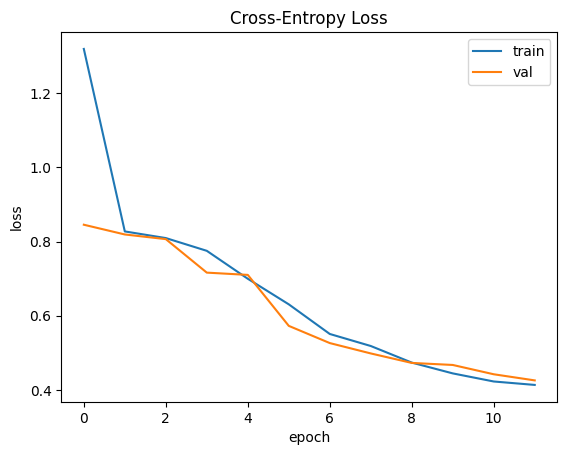

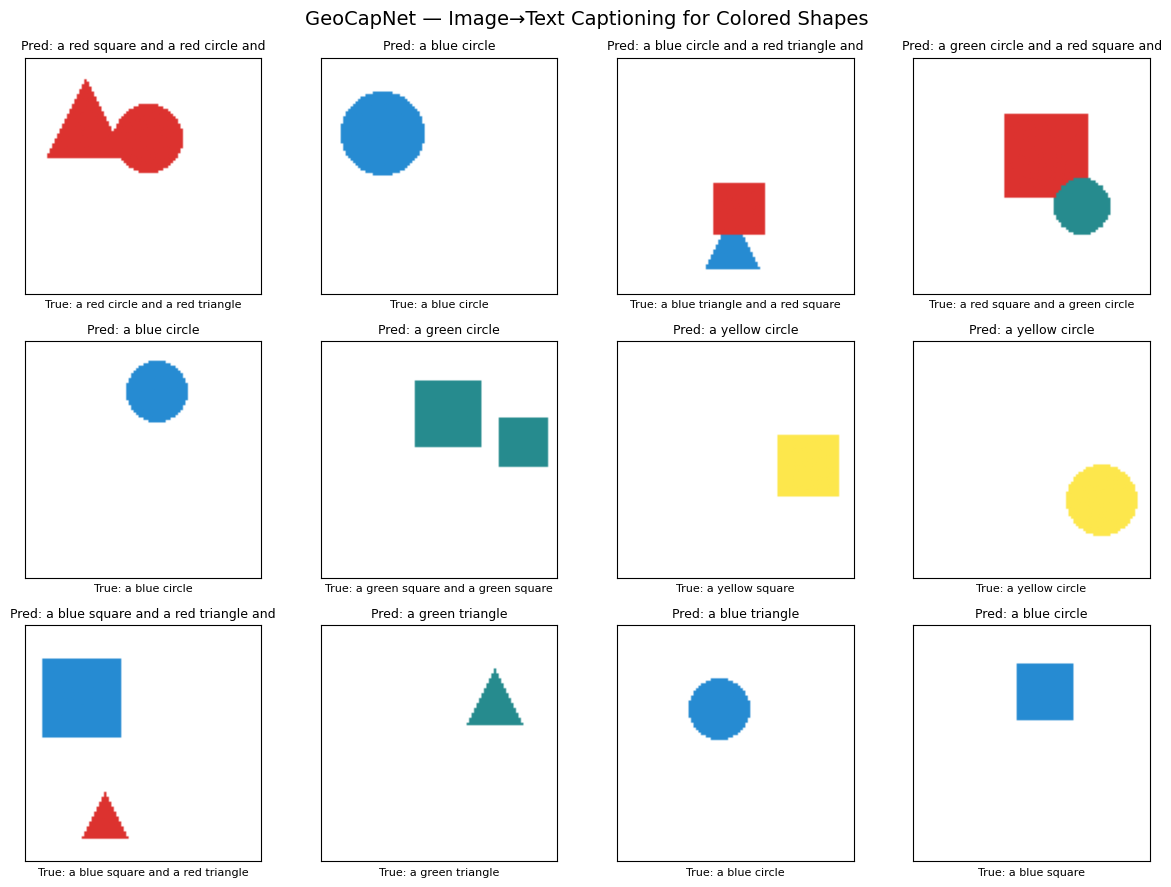

In [31]:
if __name__ == "__main__":
    train()
